<a href="https://colab.research.google.com/github/yusica09/seoul-AI-hub-study/blob/main/2%EC%A3%BC%EC%B0%A8/Q5_fashion_MNIST_keras(%2Binitialize).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

### 데이터 로드
* TF에서 제공하는 데이터셋을 load해 간단한 전처리 진행

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [7]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [8]:
print(train_data.shape, train_labels.shape)

(48600, 28, 28) (48600,)


In [9]:
print(valid_data.shape, valid_labels.shape)

(5400, 28, 28) (5400,)


label = 1


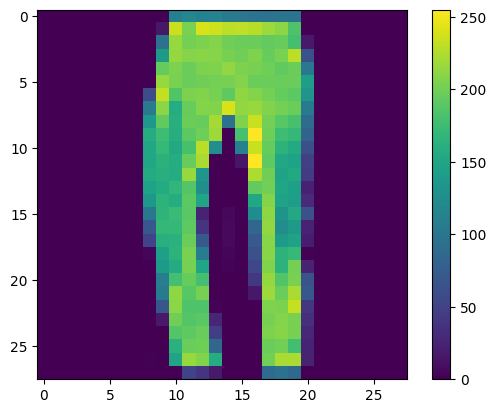

In [12]:
index = 5001
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [13]:
train_data = train_data / 255.
train_data = train_data.reshape(-1, 28*28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 28*28)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 28*28)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(48600, 784) (48600,)
(10000, 784) (10000,)
(5400, 784) (5400,)


### 학습에 사용할 tf.data.Dataset 구성
* 학습에 잘 적용할 수 있도록 label 처리
* 데이터셋 구성

In [14]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [15]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

# print를 이용하여 정보를 확인하는 것이 중요

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### 모델 구성

In [19]:
# Dense 64 relu
# Dense 32 relu
# Output Layer
# input shape은 실수하는 경우가 많으므로 자동으로 가져오게 하는 편이 좋다.
# 28 * 28
model = tf.keras.Sequential([
    # 학습이 잘 안될때 (학습 시작이 안될때) initializer 사용. layer별로 다 써줘야함
    layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Dense(10)
])

In [20]:
# from_logits = True 잊지말기
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[ 0.78640056  0.4220591   0.02465916  0.9261334  -0.12773864  0.38868362
  -0.06126451 -0.45879823 -0.10224664  0.05816257]]


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 64)                   50240     
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                                 
 dense_2 (Dense)             (1, 16)                   528       
                                                                 
 dense_3 (Dense)             (1, 10)                   170       
                                                                 
Total params: 53018 (207.10 KB)
Trainable params: 53018 (207.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습 구성

In [23]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [24]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                   )

Epoch 1/100
1518/1518 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.7177
Epoch 1: val_loss improved from inf to 0.57521, saving model to fashion_mnist_model.h5
1518/1518 [==============================] - 9s 5ms/step - loss: 0.8749 - accuracy: 0.7177 - val_loss: 0.5752 - val_accuracy: 0.8136
Epoch 2/100
  40/1518 [..............................] - ETA: 5s - loss: 0.5458 - accuracy: 0.8297

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1514/1518 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.8273
Epoch 2: val_loss improved from 0.57521 to 0.48454, saving model to fashion_mnist_model.h5
1518/1518 [==============================] - 8s 5ms/step - loss: 0.5196 - accuracy: 0.8273 - val_loss: 0.4845 - val_accuracy: 0.8385
Epoch 3/100
1514/1518 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.8444
Epoch 3: val_loss improved from 0.48454 to 0.44414, saving model to fashion_mnist_model.h5
1518/1518 [==============================] - 6s 4ms/step - loss: 0.4586 - accuracy: 0.8444 - val_loss: 0.4441 - val_accuracy: 0.8501
Epoch 4/100
1511/1518 [============================>.] - ETA: 0s - loss: 0.4264 - accuracy: 0.8540
Epoch 4: val_loss improved from 0.44414 to 0.42153, saving model to fashion_mnist_model.h5
1518/1518 [==============================] - 9s 6ms/step - loss: 0.4266 - accuracy: 0.8538 - val_loss: 0.4215 - val_accuracy: 0.8551
Epoch 5/100
1509/1518 [====================

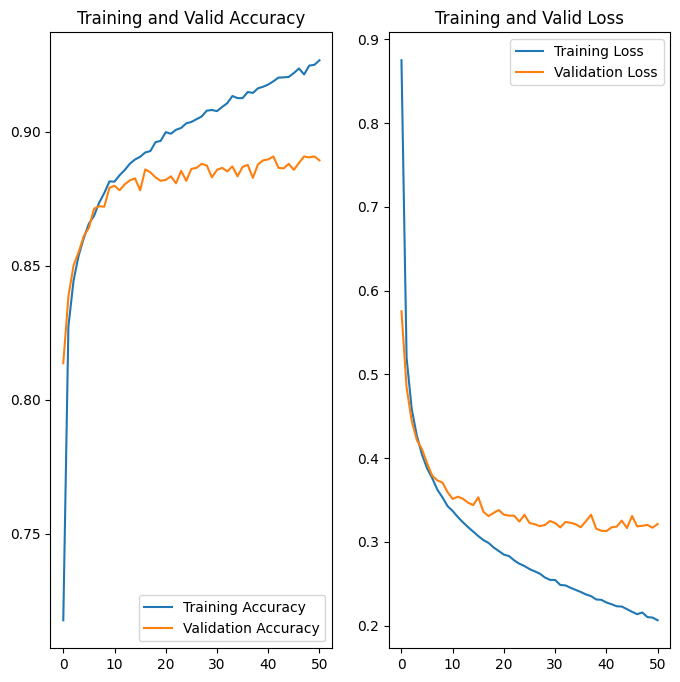

In [25]:
# 그래프에서 1)학습이 잘되었는지 확인 2)overfitting 발생여부 3)개선방향
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [26]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8802
